# Ejercicio de proyecto: Ingeniería de características

La ingeniería de características es el acto de facilitar la comprensión de los datos para que un modelo de machine learning los comprenda. No estás añadiendo nada nuevo, sino que estás reconfigurando y seleccionando los datos existentes para que los patrones existentes sean más evidentes. La ingeniería de características es el proceso de utilizar el conocimiento de dominio de los datos para crear características que hacen que los algoritmos de machine learning funcionen mejor de lo que lo harían en una simple codificación sin procesar.

Para examinar esto, utilizarás el conjunto de datos de vivienda (licencia CC0) del Condado de King, Washington (que incluye Seattle). Tratarás de predecir el precio de una casa basándote en información simple, como la ubicación, el total de pies cuadrados y el número de habitaciones. Puedes imaginarte un escenario empresarial en el que diriges una agencia inmobiliaria y deseas predecir para tus clientes el coste al que se venderá una casa si se pone a la venta.

Primero, carga el conjunto de datos y echa un vistazo a tus propiedades básicas.

In [23]:
%%capture

%pip install --upgrade boto3 -q

# Load the dataset
import pandas as pd
import boto3

df = pd.read_csv("/home/ec2-user/SageMaker/kc_house_data_2.csv")
df.head()

Este conjunto de datos tiene 21 columnas:
* `id`: número de identificación único
* `date`: fecha de la venta de la casa
* `price`: precio por el que se vendió la casa
* `bedrooms`: número de dormitorios
* `bathrooms`: número de baños
* `sqft_living`: número de pies cuadrados del espacio habitable
* `sqft_lot`: número de pies cuadrados de la parcela
* `floors`: número de plantas de la casa
* `waterfront`: si la casa está en el paseo marítimo
* `view`: número de lados de la parcela con una vista
* `condition`: estado de la casa
* `grade`: clasificación por calidad de la construcción 
* `sqft_above`: número de pies cuadrados sobre el suelo
* `sqft_basement`: número de pies cuadrados debajo del suelo
* `yr_built`: año de construcción
* `yr_renovated`: año de renovación
* `zipcode`: código postal
* `lat`: latitud
* `long`: longitud
* `sqft_living15`: número de pies cuadrados de espacio habitable en 2015 (puede diferir de `sqft_living` en el caso de renovaciones recientes)
* `sqrt_lot15`: número de pies cuadrados de espacio de la parcela en 2015 (puede diferir de `sqft_lot` en el caso de renovaciones recientes)

Este conjunto de datos es rico y proporciona un fantástico espacio para la exploración de la ingeniería de características. Este ejercicio se centrará en un pequeño número de columnas. Si estás interesado, podrías volver a este conjunto de datos más adelante para practicar la ingeniería de características en las columnas restantes.

In [24]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.234303,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.766318,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,4.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Un modelo de referencia

Ahora, entrena un modelo de referencia.

Las personas a menudo miran los pies cuadrados primero al evaluar una casa. Harás lo mismo en tu modelo y preguntarás hasta cuánto puede aproximarse el coste de la casa basándose solo en este número. Entrenarás un [modelo de aprendiz lineal simple](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html)).

**Nota:** Esto tarda unos minutos en ejecutarse, así que puedes seguir leyendo si quieres mientras esperas.

In [25]:
import sagemaker
import numpy as np
from sklearn.model_selection import train_test_split
import time

t1 = time.time()

# Split training, validation, and test
ys = np.array(df['price']).astype("float32")
xs = np.array(df['sqft_living']).astype("float32").reshape(-1,1)

np.random.seed(8675309)
train_features, test_features, train_labels, test_labels = train_test_split(xs, ys, test_size=0.2)
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)

# Train model
linear_model = sagemaker.LinearLearner(role=sagemaker.get_execution_role(), instance_count=1, instance_type='ml.m4.xlarge', predictor_type='regressor')

train_records = linear_model.record_set(train_features, train_labels, channel='train')
val_records = linear_model.record_set(val_features, val_labels, channel='validation')

linear_model.fit([train_records, val_records], logs=False)

sagemaker.analytics.TrainingJobAnalytics(linear_model._current_job_name, metric_names = ['validation:mse', 'validation:absolute_loss']).dataframe()

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-06-06-08-06-01-530



2024-06-06 08:06:02 Starting - Starting the training job.
2024-06-06 08:06:16 Starting - Preparing the instances for training.....
2024-06-06 08:06:46 Downloading - Downloading input data....
2024-06-06 08:07:11 Downloading - Downloading the training image..............
2024-06-06 08:08:27 Training - Training image download completed. Training in progress.......
2024-06-06 08:09:02 Uploading - Uploading generated training model..
2024-06-06 08:09:16 Completed - Training job completed


,timestamp,metric_name,value
0,0.0,validation:mse,6.240912e+10
1,0.0,validation:absolute_loss,1.692545e+05


Si examinas las métricas de calidad, verás que la pérdida absoluta es de aproximadamente $\$169 000,00 USD. Esto nos dice que el modelo es capaz de predecir dentro de un promedio de 169 000 USD del precio real. Esto no está mal para un modelo basado en una sola variable. Vamos a tratar de hacer algo de ingeniería de características para mejorarlo.

A lo largo del siguiente trabajo, constantemente añadirás a un DataFrame llamado `encoded`. Comenzarás rellenando `encoded` solo con los pies cuadrados que has usado anteriormente.

In [26]:
encoded = df[['sqft_living']].copy()

## Variables categóricas

Comencemos por incluir algunas variables categóricas, empezando con variables binarias simples.

El conjunto de datos tiene la característica `waterfront`, que es una variable binaria. Deberíamos cambiar la codificación de `'Y'` y `'N'` a `1` y `0`. Esto se puede hacer mediante la función `map` ([documentación](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html)) que Pandas proporciona. Se espera que una función se aplique a esa columna o un diccionario para buscar la transformación correcta.

> ### Pregunta 1: Categórica binaria
> Escribe código para transformar la variable `waterfront` en valores binarios. El esquema se proporciona a continuación.

In [27]:
## SOLUTION 1 ##

encoded['waterfront'] = df['waterfront'].map({'Y':1, 'N':0})

También puedes codificar muchas variables categóricas de clase. Mira la columna `condition`, que da una puntuación de la calidad de la casa. Si miras en [origen de datos](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#b), se muestra que la condición puede pensarse como una variable categórica ordinal, por lo que tiene sentido codificarla con el orden.

> ### Pregunta 2: Categórica ordinal
> Usando el mismo método que en la pregunta 1, codifica la variable categórica ordinal `condition` en el rango numérico del 1 al 5.

In [28]:
## SOLUTION 2 ##

encoded['condition'] = df['condition'].map({'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5})

Una variable categórica un poco más compleja es el código postal. Si has trabajado con datos geoespaciales, es posible que sepas que el código postal completo suele ser demasiado fino para usarlo como una característica por sí mismo. No obstante, solo hay $70$ códigos postales únicos en este conjunto de datos, por lo que podemos usarlos.

Sin embargo, no queremos usar códigos postales sin codificar. No hay ninguna razón para que un código postal más grande corresponda a un precio más alto o más bajo, pero es probable que los códigos postales particulares sí. Este es el caso perfecto para realizar una codificación one-hot. Puedes utilizar la función `get_dummies` ([documentación](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)) de Pandas para hacerlo.

> ### Pregunta 3: Categórica nominal
> Mediante la función `get_dummies` de Pandas, añade columnas para codificar en one-hot el código postal y añádelas al conjunto de datos.

In [29]:
## Solution 3 ##

encoded = pd.concat([encoded, pd.get_dummies(df['zipcode'])], axis=1)

De esta manera, puedes codificar libremente las variables categóricas que desees. Ten en cuenta que para las variables categóricas con muchas categorías, habrá que hacer algo para reducir el número de columnas creadas.

Una técnica adicional, que es simple, pero puede tener mucho éxito, consiste en convertir el código postal en una sola columna numérica mediante la creación de una única característica que es el precio promedio de una casa en ese código postal. Esto se llama codificación de destino.

Para ello, utiliza `groupby` ([documentación](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) y `mean` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html)) para agrupar primero las filas del DataFrame por código postal y luego tomar la media de cada grupo. El objeto que resulta se puede asignar sobre la columna de código postal para codificar la característica.

> ### Pregunta 4: Categórica nominal II
> Completa el siguiente fragmento de código para proporcionar una codificación de destino para el código postal.  

In [30]:
## Solution 4 ##
means = df.groupby('zipcode')['price'].mean()
encoded['zip_mean'] = df['zipcode'].map(means)

Normalmente, solo puedes codificar en one-hot o en destino. Para este ejercicio, deje ambos. En la práctica, debes probar ambos, ver cuál funciona mejor en un conjunto de validación y luego usar ese método.

## Escalado

Echa un vistazo al conjunto de datos. Imprime un resumen del conjunto de datos codificado mediante `describe` ([documentación](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)).

In [31]:
encoded.describe()

,sqft_living,waterfront,condition,zip_mean
count,21613.000000,21613.000000,21613.000000,2.161300e+04
mean,2079.899736,0.007542,3.409430,5.400881e+05
std,918.440897,0.086517,0.650743,2.343263e+05
min,290.000000,0.000000,1.000000,2.342840e+05
25%,1427.000000,0.000000,3.000000,3.594832e+05
50%,1910.000000,0.000000,3.000000,4.935525e+05
75%,2550.000000,0.000000,4.000000,6.452315e+05
max,13540.000000,1.000000,5.000000,2.160607e+06


Una columna oscila entre $290$ y $13 540$ (`sqft_living`), otra columna oscila entre $1$ y $5$ (`condition`), $71$ columnas son todas $0$ o $1$ (código postal codificado en one-hot), y luego la columna final oscila entre unos pocos cientos de miles a un par de millones (`zip_mean`).

En un modelo lineal, estos no estarán en igualdad de condiciones. La columna `sqft_living` será aproximadamente $13 000$ veces más fácil para que el modelo encuentre un patrón que en las otras columnas. Para resolver esto, a menudo debes escalar características a un rango estandarizado. En este caso, escalará `sqft_living` para que esté dentro de $0$ y $1$.

> ### Pregunta 5: Escalado de características
> Rellena el siguiente esquema de código para escalar la columna del DataFrame para que esté entre $0$ y $1$.

In [32]:
## Solution 5 ##

sqft_min = encoded['sqft_living'].min()
sqft_max = encoded['sqft_living'].max()
encoded['sqft_living'] = encoded['sqft_living'].map(lambda x : (x-sqft_min)/(sqft_max - sqft_min))

cond_min = encoded['condition'].min()
cond_max = encoded['condition'].max()
encoded['condition'] = encoded['condition'].map(lambda x : (x-cond_min)/(cond_max - cond_min))

zipmean_min = encoded['zip_mean'].min()
zipmean_max = encoded['zip_mean'].max()
encoded['zipmean'] = encoded['zip_mean'].map(lambda x : (x-zipmean_min)/(zipmean_max - zipmean_min))

## Comparación con la referencia

Al haberla completado, ya has practicado algunos aspectos fundamentales de la ingeniería de características. Echa un vistazo a cómo se compara el nuevo modelo con la referencia.

In [33]:
# Split training, validation, and test
ys = np.array(df['price']).astype("float32")
xs = np.array(encoded).astype("float32")

np.random.seed(8675309)
train_features, test_features, train_labels, test_labels = train_test_split(xs, ys, test_size=0.2)
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)

# Train model
linear_model = sagemaker.LinearLearner(role=sagemaker.get_execution_role(), instance_count=1, instance_type='ml.m4.xlarge', predictor_type='regressor')

train_records = linear_model.record_set(train_features, train_labels, channel='train')
val_records = linear_model.record_set(val_features, val_labels, channel='validation')

linear_model.fit([train_records, val_records], logs=False)

sagemaker.analytics.TrainingJobAnalytics(linear_model._current_job_name, metric_names = ['validation:mse', 'validation:absolute_loss']).dataframe()

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-06-06-08-09-20-960



2024-06-06 08:09:22 Starting - Starting the training job.
2024-06-06 08:09:35 Starting - Preparing the instances for training....
2024-06-06 08:10:01 Downloading - Downloading input data......
2024-06-06 08:10:31 Downloading - Downloading the training image.............
2024-06-06 08:11:47 Training - Training image download completed. Training in progress.....
2024-06-06 08:12:12 Uploading - Uploading generated training model..
2024-06-06 08:12:26 Completed - Training job completed


,timestamp,metric_name,value
0,0.0,validation:mse,3.049854e+10
1,0.0,validation:absolute_loss,1.045247e+05


¡Esto ha mejorado! El error se ha reducido de aproximadamente $\$169k$ a $\$104k$, lo que supone una mejora del $38\ %$ en las predicciones.

Profundizar en la ingeniería de características suele ser uno de los pasos más potentes en el desarrollo de un modelo. Si utilizas la comprensión humana para realizar características bien diseñadas, será una cosa menos que el modelo tendrá que aprender.

Si bien aquí omitimos el análisis de datos exploratorios, hacerlo revelaría rápidamente que hay muchas relaciones sutiles que se pueden modelar, como la que se representa a continuación para `price` frente a `lat`. ¿Puedes adivinar la latitud del centro de Seattle desde este diagrama?

INFO:matplotlib.font_manager:generated new fontManager


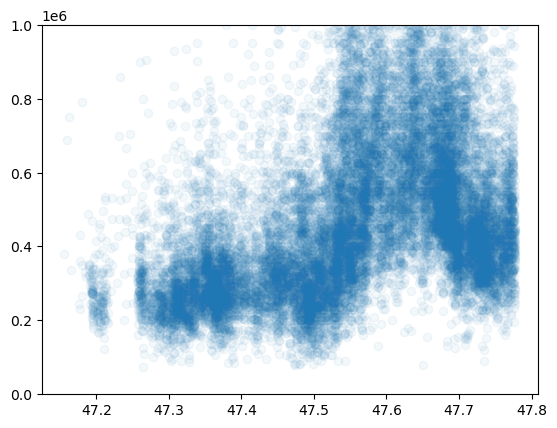

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.ylim([0,1000000])
plt.scatter(df['lat'],df['price'],alpha=0.05)
plt.show()

> ### Pregunta 6: Ingeniería de características adicional (Opcional)
> Continúa realizando ingeniería de características en este conjunto de datos. Aquí hay una breve lista de cosas para probar:
> * Realiza la ingeniería de características polinómicas o de rangos en la latitud.
> * Intenta usar solo los tres primeros dígitos del código postal para ver si es preferible tener menos variables codificadas en one-hot.
> * Incluye las otras características numéricas.
> * Prueba el efecto de diferentes métodos de escalado.
> * Utiliza el año de renovación para crear una variable `has_been_renovated`. (¿Qué saldría mal si lo usaras sin codificarlo correctamente?)
> * Utiliza la fecha de venta.

In [35]:
## Possible solution 6 ##

encoded['bedrooms'] = df['bedrooms']
encoded['bathrooms'] = df['bathrooms']
encoded['sqft_lot'] = df['sqft_lot']
encoded['floors'] = df['floors']
encoded['view'] = df['view']
encoded['grade'] = df['grade']
encoded['sqft_above'] = df['sqft_above']
encoded['sqft_basement'] = df['sqft_basement']
encoded['renovated'] = df['yr_renovated'].map(lambda x: 1 if x > 0 else 0)
encoded['lat'] = df['lat']
encoded['long'] = df['long']
encoded['lr1'] = df['lat'].map(lambda x: 1 if x <= 47.3 else 0)
encoded['lr2'] = df['lat'].map(lambda x: 1 if x > 47.3 and x <= 47.4 else 0)
encoded['lr3'] = df['lat'].map(lambda x: 1 if x > 47.4 and x <= 47.5 else 0)
encoded['lr4'] = df['lat'].map(lambda x: 1 if x > 47.5 and x <= 47.6 else 0)
encoded['lr5'] = df['lat'].map(lambda x: 1 if x > 47.6 and x <= 47.7 else 0)
encoded['lr6'] = df['lat'].map(lambda x: 1 if x > 47.7 else 0)

encoded = (encoded.astype(np.float32) - (encoded.min()).astype(np.float32))/((encoded.max()).astype(np.float32) - (encoded.min()).astype(np.float32))

In [36]:
encoded.describe()

,sqft_living,waterfront,condition,98001,98002,98003,98004,98005,98006,98007,...,sqft_basement,renovated,lat,long,lr1,lr2,lr3,lr4,lr5,lr6
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,0.135087,0.007542,0.602357,0.016749,0.009207,0.012955,0.014667,0.007773,0.023042,0.006524,...,0.060479,0.042289,0.650078,0.253407,0.037755,0.136862,0.131217,0.255957,0.270902,0.167307
std,0.069317,0.086516,0.162685,0.128322,0.095522,0.113074,0.120214,0.087827,0.150023,0.080518,...,0.091821,0.201241,0.222878,0.116967,0.190594,0.343706,0.337670,0.436395,0.444453,0.373277
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.085811,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.506839,0.158634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.122264,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.668974,0.240029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.170566,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.116183,0.000000,0.839797,0.327242,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
# Split training, validation, and test
ys = np.array(df['price']).astype("float32")
xs = np.array(encoded).astype("float32")

np.random.seed(8675309)
train_features, test_features, train_labels, test_labels = train_test_split(xs, ys, test_size=0.2)
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)

# Train model
linear_model = sagemaker.LinearLearner(role=sagemaker.get_execution_role(), instance_count=1, instance_type='ml.m4.xlarge', predictor_type='regressor')

train_records = linear_model.record_set(train_features, train_labels, channel='train')
val_records = linear_model.record_set(val_features, val_labels, channel='validation')

linear_model.fit([train_records, val_records], logs=False)

sagemaker.analytics.TrainingJobAnalytics(linear_model._current_job_name, metric_names = ['validation:mse', 'validation:absolute_loss']).dataframe()

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-06-06-08-12-41-305



2024-06-06 08:12:42 Starting - Starting the training job.
2024-06-06 08:12:56 Starting - Preparing the instances for training.....
2024-06-06 08:13:26 Downloading - Downloading input data....
2024-06-06 08:13:51 Downloading - Downloading the training image..............
2024-06-06 08:15:06 Training - Training image download completed. Training in progress......
2024-06-06 08:15:37 Uploading - Uploading generated training model..
2024-06-06 08:15:50 Completed - Training job completed


,timestamp,metric_name,value
0,0.0,validation:mse,2.559593e+10
1,0.0,validation:absolute_loss,9.705773e+04


# Optimización de hiperparámetros

Ahora que has preparado y entrenado el conjunto de datos, es hora de ajustar el modelo. Lo que ajusta para el modelo son los mandos o configuraciones del algoritmo llamados hiperparámetros. Los hiperparámetros pueden afectar drásticamente al rendimiento de los modelos entrenados. Por ejemplo, el algoritmo de aprendiz lineal tiene docenas de hiperparámetros, y debes elegir los valores correctos para esos hiperparámetros a fin de lograr los resultados deseados del entrenamiento de modelos. La selección de la configuración de hiperparámetros que conduce al mejor resultado depende también del conjunto de datos. Es casi imposible elegir la mejor configuración de hiperparámetros sin buscarla, y un buen algoritmo de búsqueda puede buscar la mejor configuración de hiperparámetros de forma automatizada y efectiva.

Utilizarás la optimización de hiperparámetros de Amazon SageMaker para automatizar el proceso de búsqueda con eficacia. En concreto, especificarás un rango, o una lista de posibles valores en el caso de los hiperparámetros categóricos, para cada uno de los hiperparámetros que planeamos ajustar. El ajuste de hiperparámetros de Amazon SageMaker iniciará automáticamente varios trabajos de entrenamiento con diferentes configuraciones de hiperparámetros, evaluará los resultados de esos trabajos de entrenamiento en función de una “métrica objetiva” predefinida y seleccionará la configuración de hiperparámetros para futuros intentos basados en resultados anteriores. Para cada trabajo de ajuste de hiperparámetros, darás un presupuesto (número máximo de trabajos de entrenamiento) y el ajuste se completará una vez que se hayan ejecutado muchos trabajos de entrenamiento.

Volverás a utilizar el SDK de Python de Amazon SageMaker para configurar y administrar el trabajo de ajuste de hiperparámetros.

Ajustarás dos hiperparámetros en este ejemplo:
- **learning_rate:** el tamaño del paso usado por el optimizador para actualizaciones de parámetros
- **use_bias:** especifica si el modelo debe incluir un término de sesgo, que es el término de interceptar de la ecuación lineal

In [38]:
from sagemaker.parameter import (
    CategoricalParameter,
    ContinuousParameter,
    IntegerParameter,
    ParameterRange,
)
from sagemaker.amazon.hyperparameter import Hyperparameter
from sagemaker.tuner import HyperparameterTuner
import sagemaker

hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.0001, 0.1, scaling_type='Logarithmic'),
                        'use_bias': CategoricalParameter([True, False])}

A continuación, especificarás la métrica objetiva que deseas ajustar y su definición, que incluye la expresión regular (regex) necesaria para extraer esa métrica de los Amazon CloudWatch logs del trabajo de entrenamiento.

Dado que estás utilizando el algoritmo de aprendiz lineal integrado, emite dos métricas predefinidas que has utilizado antes: **test: mse** y **test: absolute_loss**. Elegirás supervisar **test:mse**. En este caso, solo necesitas especificar el nombre de la métrica y no es necesario proporcionar expresiones regulares. Si traes tu propio algoritmo, tu algoritmo emite métricas por sí mismo. En ese caso, tendrías que añadir un objeto de definición de métrica para definir el formato de esas métricas mediante expresiones regulares, de modo que Amazon SageMaker sepa cómo extraer esas métricas de los registros de CloudWatch.

In [39]:
objective_metric_name = 'validation:mse'
objective_type = 'Minimize'

Ahora, crea un objeto HyperParameterTuner, al que pasarás lo siguiente:  
- El estimador Linear_model creado previamente
- Los intervalos de los hiperparámetros
- Nombre y definición de la métrica objetiva con el tipo de objetivo
- Configuraciones de recursos de ajuste, como el número de trabajos de entrenamiento que se pondrán en marcha en total y cuántos trabajos de entrenamiento se pueden poner en marcha en paralelo

In [40]:
tuner = HyperparameterTuner(linear_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=2,
                            objective_type=objective_type)

Ahora puedes iniciar un trabajo de ajuste de hiperparámetros llamando a la función `fit()`. Una vez creado el trabajo de ajuste de hiperparámetros, puedes ir a la consola de Amazon SageMaker para realizar un seguimiento del progreso del trabajo de ajuste de hiperparámetros hasta que se complete.

In [41]:
tuner.fit([train_records, val_records], include_cls_metadata=False)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: linear-learner-240606-0815


..............................................................................!


Ejecuta una comprobación rápida del estado del trabajo de ajuste de hiperparámetros para asegurarte de que se inició correctamente.

In [42]:
sagemaker_client = boto3.client('sagemaker')

job_name = tuner.latest_tuning_job.job_name

tuner_describe = sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name)['HyperParameterTuningJobStatus']
tuner_describe

'Completed'

### Realizar un seguimiento del progreso del trabajo de ajuste de hiperparámetros

Después de iniciar un trabajo de ajuste, puedes ver el progreso invocando la API `describe_tuning_job`. La salida es un objeto JSON que contiene información sobre el estado actual del trabajo de ajuste. Para ver una lista detallada de los trabajos de entrenamiento iniciados por el trabajo de ajuste, llama a `list_training_jobs_for_tuning_job`.

In [43]:
tuning_job_result = sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

10 training jobs have completed


In [44]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2024, 6, 6, 8, 16, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mse',
                                                 'Value': 25604583424.0},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 6, 6, 8, 19, 9, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:032264664177:training-job/linear-learner-240606-0815-002-2184bbef',
 'TrainingJobName': 'linear-learner-240606-0815-002-2184bbef',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 6, 6, 8, 16, 40, tzinfo=tzlocal()),
 'TunedHyperParameters': {'learning_rate': '0.004560169142708778',
                          'use_bias': 'True'}}


### Obtener todos los resultados como DataFrame

Puedes enumerar los hiperparámetros y las métricas objetivas de todos los trabajos de entrenamiento y seleccionar el trabajo de entrenamiento con la mejor métrica objetiva.

In [45]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', None)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df



Number of training jobs with valid objective: 10
{'lowest': 25604583424.0, 'highest': 55400783872.0}


,learning_rate,use_bias,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
8,0.004560,True,linear-learner-240606-0815-002-2184bbef,Completed,2.560458e+10,2024-06-06 08:16:40+00:00,2024-06-06 08:19:09+00:00,149.0
5,0.014047,False,linear-learner-240606-0815-005-2fff564d,Completed,2.643172e+10,2024-06-06 08:20:05+00:00,2024-06-06 08:20:38+00:00,33.0
0,0.001771,True,linear-learner-240606-0815-010-c1970d39,Completed,2.645743e+10,2024-06-06 08:21:49+00:00,2024-06-06 08:22:27+00:00,38.0
7,0.015056,False,linear-learner-240606-0815-003-54e0410b,Completed,2.652703e+10,2024-06-06 08:19:16+00:00,2024-06-06 08:19:50+00:00,34.0
3,0.007022,False,linear-learner-240606-0815-007-bbcd91d1,Completed,2.671448e+10,2024-06-06 08:20:54+00:00,2024-06-06 08:21:28+00:00,34.0
2,0.039045,False,linear-learner-240606-0815-008-0e04dea9,Completed,2.849341e+10,2024-06-06 08:21:01+00:00,2024-06-06 08:21:35+00:00,34.0
4,0.000787,True,linear-learner-240606-0815-006-bdb5dbce,Completed,3.142364e+10,2024-06-06 08:20:07+00:00,2024-06-06 08:20:45+00:00,38.0
1,0.002364,False,linear-learner-240606-0815-009-43b8aef5,Completed,3.201340e+10,2024-06-06 08:21:47+00:00,2024-06-06 08:22:22+00:00,35.0
6,0.000580,True,linear-learner-240606-0815-004-67b55994,Completed,3.637064e+10,2024-06-06 08:19:17+00:00,2024-06-06 08:19:51+00:00,34.0
9,0.000334,True,linear-learner-240606-0815-001-57f53e7f,Completed,5.540078e+10,2024-06-06 08:16:44+00:00,2024-06-06 08:19:03+00:00,139.0


## Conclusión

En este ejercicio, has examinado algunas tareas de ingeniería de características y optimización de hiperparámetros. En primer lugar, has visto cómo puedes codificar características que de otro modo no son accesibles para el modelo (como las características categóricas). En estas circunstancias, técnicas simples como la codificación one-hot o la codificación ordinal pueden recorrer un largo camino. Estas técnicas también le permitieron obtener más de las características que ya tenía, como en el caso de la latitud. La codificación ya era buena en ese caso; sin embargo, el patrón era difícil de usar para el modelo. Presentar esa variable de manera que los datos estén disponibles para el modelo es clave para el desarrollo de un modelo de alto rendimiento.